<a href="https://colab.research.google.com/github/garrisonz/reproduce/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l
!pip install ipython-autotime
%load_ext autotime

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

time: 3.64 s (started: 2022-06-27 07:58:28 +00:00)


In [3]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

time: 4.63 ms (started: 2022-06-27 07:58:32 +00:00)


In [4]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

time: 5.97 ms (started: 2022-06-27 07:58:32 +00:00)


In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

time: 1.43 ms (started: 2022-06-27 07:58:32 +00:00)


In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

time: 5.13 ms (started: 2022-06-27 07:58:32 +00:00)


In [7]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

time: 32.6 ms (started: 2022-06-27 07:58:32 +00:00)


In [8]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

time: 3.27 ms (started: 2022-06-27 07:58:32 +00:00)


In [9]:
X = torch.randn(1, 1, 224, 224)
for l in net:
    X = l(X)
    print(l.__class__.__name__, X.shape)

Sequential torch.Size([1, 64, 56, 56])
DenseBlock torch.Size([1, 192, 56, 56])
Sequential torch.Size([1, 96, 28, 28])
DenseBlock torch.Size([1, 224, 28, 28])
Sequential torch.Size([1, 112, 14, 14])
DenseBlock torch.Size([1, 240, 14, 14])
Sequential torch.Size([1, 120, 7, 7])
DenseBlock torch.Size([1, 248, 7, 7])
BatchNorm2d torch.Size([1, 248, 7, 7])
ReLU torch.Size([1, 248, 7, 7])
AdaptiveAvgPool2d torch.Size([1, 248, 1, 1])
Flatten torch.Size([1, 248])
Linear torch.Size([1, 10])
time: 228 ms (started: 2022-06-27 07:58:32 +00:00)


loss 0.141, train acc 0.948, test acc 0.874
3026.1 examples/sec on cuda:0


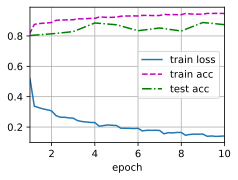

time: 4min 17s (started: 2022-06-27 07:58:32 +00:00)


In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())